# **Load Libraries/Install Software**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install torchtext --upgrade -qq
!pip install torchmetrics -qq
!pip install torchinfo -qq

basepath = '/content/drive/MyDrive/ColabNotebooks/NLP-HPS/Homeworks'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.6 MB/s eta 0:00:00


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np
import pandas as pd


# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt

# For converting the Target variable to binary labeled data
from sklearn.preprocessing import MultiLabelBinarizer

# For converting a string object to a specific python defined data structure
import ast

# For splitting the dataset
from sklearn.model_selection import train_test_split


# **Load Data**

In [3]:
base_folder = Path(basepath)
data_folder = base_folder /'Data/Stack_Exchange_Multilabel_Data'
model_folder = base_folder/'Models/HW3_Models_Multilabel'
custom_functions = base_folder/'custom_functions'

In [4]:
model_folder.mkdir(exist_ok=True)

In [5]:
data_file = data_folder / 'df_multilabel_hw_cleaned.joblib'

In [6]:
data = joblib.load(data_file)

# **Exploratory Data Analysis**

In [7]:
data.head(3)

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"


In [8]:
data['Tag_Number'].value_counts()

[3, 5]             19989
[0, 9]              7986
[1, 4]              6922
[2, 3]              2165
[2, 5]              1499
                   ...  
[0, 2, 3, 9, 5]        1
[3, 9, 4]              1
[2, 3, 8]              1
[1, 2, 8, 6, 4]        1
[3, 2]                 1
Name: Tag_Number, Length: 176, dtype: int64

# **Converting the String TARGET column to a binary labeled list**

In [9]:
data.dtypes  # Tag_Number is a object--> we need to convert it into list of integers

cleaned_text    object
Tags            object
Tag_Number      object
dtype: object

In [10]:
data['Tag_Number'] = data['Tag_Number'].apply(lambda x: ast.literal_eval(x))

In [11]:
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(data['Tag_Number'])

In [12]:
mlb_result.shape

(47427, 10)

In [13]:
binary_labels_list = mlb_result.tolist()
data['Tag_Number_ohe'] = binary_labels_list

In [14]:
data.head(3)

,cleaned_text,Tags,Tag_Number,Tag_Number_ohe
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


# **Splitting the DataSet**

In [15]:

X = data['cleaned_text']
y = data['Tag_Number_ohe']



In [16]:
# Split the data into 60% training and 40% holdout (validation + test)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.4, random_state=123)

# Split the holdout data into 50% validation and 50% test
X_valid, X_test, y_valid, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=123)

In [17]:
X_train.shape, y_train.shape

((28456,), (28456,))

In [18]:
X_valid.shape, y_valid.shape

((9485,), (9485,))

In [19]:
X_test.shape, y_test.shape

((9486,), (9486,))

In [20]:
type(X_train)

pandas.core.series.Series

In [21]:
type(y_train)

pandas.core.series.Series

# **Custom Dataset Class**

In [22]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading IMDB reviews and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Converting the feature data to a NumPy array for consistency
        self.X = np.array(X)

        # Storing the target labels
        self.y = np.array(y)

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [23]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_valid, y_valid)
testset = CustomDataset(X_test, y_test)

In [24]:
trainset[1][1]

'simplecursoradapter undefined sample code give grief simplecursoradapter work outside textchangedlistener get message   constructor simplecursoradapter(new textwatcher int cursor string int null undefined   txt.addtextchangedlistener(new textwatcher               public void ontextchanged(charsequence s int start int int count                  //ontextchanged                            public void beforetextchanged(charsequence s int start int count int                  //beforetextchange                             public void aftertextchanged(editable s                  //aftertextchanged                  typedtext = s.tostre                   cursor cur = db.rawquery("select +                          db_table + field like + typedtext + null                  stre displayfield = field                  int displayview = r.id.bmark_visit                  setlistadapter(new simplecursoradapter(this                                   cur                                   displayfield dis

In [25]:
trainset[1][0]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

In [26]:
len(trainset)

28456

# **Create Vocab**

In [27]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (l_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [28]:
stack_exchange_vocab = get_vocab(trainset, min_freq=2)

In [29]:
len(stack_exchange_vocab)

90881

In [30]:
stack_exchange_vocab.get_itos()[0:5]

['<unk>', 'jquery', 'fn', 'load', 'working']

In [31]:
stack_exchange_vocab['<unk>']

0

In [32]:
type(stack_exchange_vocab)

torchtext.vocab.vocab.Vocab

# **Collate_fn for Data Loaders**

In [33]:
# Creating a function that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [34]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)


    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.float)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [text_pipeline(text, my_vocab) for text in texts]

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])


    return (texts, offsets), labels

# **Check Data Loaders**

In [35]:
batch_size = 5
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=partial(collate_batch, my_vocab = stack_exchange_vocab),
                                           )

In [36]:
torch.manual_seed(22)
for (text, offset), label in check_loader:
    print(text,offset,label)
    break




tensor([    1,  3197,   361,   197,   140,  6131,   140,   101,   704,   197,
          179,   704,   714,   411,    38,   140,  1933, 35196,  3694,  3782,
           41, 34987,  2985, 35197,    11, 35198, 16743, 35199, 35200,   108,
        35201,    72,    62, 35201,    72,    72,    62,    41, 34987,  2985,
         1398, 35202,  6655,    41, 35203, 16743, 35204, 35201,    72,   634,
        35205, 35201,    72,    72,   634,    41, 34987,  2985,  1398, 35202,
        15949,    41, 35203, 16743, 35206,  3668,    76, 35201,   168,   333,
         4713,  4472,   353,   680,  1866,   309, 46195, 63090,   353,   724,
           89,  4713,  4472,   353,    23,   155,   411,   680,    15,    89,
          212,   353,  3311,  1008, 63091, 63092,   381,   381,   693,   289,
          173,   255,    15,    89,   415,   173,  4713,  4472,   353,    23,
        46195, 63090,   724,    23,    95,   291,   104,  2321,   792,   408,
          212,  2321,  1424,   104,  2321,   324,   104,  8700, 

# **Model**

In [37]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.BatchNorm1d(num_features=output_dim)

        )
    def forward(self, x):
      return self.layers(x)

In [38]:
class CustomMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.layers = nn.Sequential(
            CustomBlock(embedding_dim , hidden_dim1, drop_prob1),
            CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, input_tuple):
        data, offsets = input_tuple
        embed_out = self.embedding_bag(data, offsets)
        out = self.layers(embed_out)

        return out

In [39]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define the sequential model
model_embedding_2 = CustomMLP(vocab_size=7 , embedding_dim=10, hidden_dim1=5, hidden_dim2=3, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)

# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.tensor([1, 2, 4, 5, 4], dtype = torch.int32).to(device)
offsets = torch.tensor([0, 2, 4], dtype = torch.int32).to(device)

# Generate summary
summary(model_embedding_2, input_data=[(data, offsets)], device=device, depth =4)

Layer (type:depth-idx)                   Output Shape              Param #
CustomMLP                                [3, 10]                   --
├─EmbeddingBag: 1-1                      [3, 10]                   70
├─Sequential: 1-2                        [3, 10]                   --
│    └─CustomBlock: 2-1                  [3, 5]                    --
│    │    └─Sequential: 3-1              [3, 5]                    --
│    │    │    └─Linear: 4-1             [3, 5]                    55
│    │    │    └─ReLU: 4-2               [3, 5]                    --
│    │    │    └─Dropout: 4-3            [3, 5]                    --
│    │    │    └─BatchNorm1d: 4-4        [3, 5]                    10
│    └─CustomBlock: 2-2                  [3, 3]                    --
│    │    └─Sequential: 3-2              [3, 3]                    --
│    │    │    └─Linear: 4-5             [3, 3]                    18
│    │    │    └─ReLU: 4-6               [3, 3]                    --
│    │    │    

In [40]:
# Test the model
# Move the model to the device
model_embedding_2 = model_embedding_2.to(device)

# Generate some dummy input data and offsets, and move them to the device
# we will pass text as input, collate function will create data and offsets
data = torch.LongTensor([1, 2, 4, 5, 4]).to(device)
offsets = torch.LongTensor([0, 2, 4]).to(device)

# Since nn.Sequential expects a single input, we pack data and offsets into a tuple
output = model_embedding_2((data, offsets))

print(output)

tensor([[ 0.8678, -0.5998,  0.3974,  0.1841,  0.6557,  0.0937, -0.0695, -0.4128,
         -1.3471,  0.1631],
        [-0.1345,  0.0961,  0.3237,  0.0492,  0.6291, -0.9827,  0.7303, -1.2371,
         -0.5007,  1.1091],
        [ 0.6748,  1.4184,  0.6023,  0.9304,  0.0971,  0.2598,  0.7218,  0.6476,
          0.3473,  0.1480]], grad_fn=<AddmmBackward0>)


# **Model Training Functions**

## **Step Function**

In [41]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                if self.verbose:
                    print('Early stopping')
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

In [42]:
# Import HammingDistance from torchmetrics
# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance


In [43]:
def step(inputs, targets, model, device, clip_type = None, clip_value = None, loss_function=None, optimizer=None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """

    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device)



    # Early Stopping
    #early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)


    # Step 2: Calculate the number of correctly classified samples
    predicted = output>=0

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()

        loss.backward()
        # Clip gradients before the optimizer step
        # Apply gradient clipping
        for param in model.parameters():

            if param.grad is not None:
                if clip_type == 'l2':
                    torch.nn.utils.clip_grad_norm_(param, clip_value)
                elif clip_type == 'l1':
                    torch.nn.utils.clip_grad_value_(param, clip_value)
                else:
                    raise ValueError("Invalid clip_type")

        optimizer.step()

    # Return relevant metrics
    if loss_function:

        return loss, outputs, targets
    else:

        return outputs, targets

## **Train_Epoch Function**

In [55]:
def train_epoch(train_loader, model, device, clip_type, clip_value, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - train_acc (float): Training accuracy for the epoch.
    """
    # hamming distance
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:


        # Perform a forward and backward pass, updating model parameters
        loss, outputs, targets = step(inputs, targets, model, device, clip_type, clip_value, loss_function, optimizer)
        train_hamming_distance.update(outputs,targets)

        # Update running loss and correct predictions counter
        running_train_loss += loss.item()


    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)

    train_acc = train_hamming_distance.compute()
    train_hamming_distance.reset()
    return train_loss, train_acc

## **Val_Epoch Function**

In [45]:
def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_acc (float): Validation accuracy for the epoch.
    """
    # hamming distance
    valid_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    running_val_correct = 0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Perform a forward pass to get loss and number of correct predictions
            loss, outputs, targets = step(inputs, targets, model, device, loss_function=loss_function)
            # step(inputs, targets, model, device, clip_type = None, clip_value = None, loss_function=None, optimizer=None):
            # Update running loss and correct predictions counter
            valid_hamming_distance.update(outputs,targets)
            running_val_loss += loss.item()


    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_acc = valid_hamming_distance.compute()
    valid_hamming_distance.reset()
    return val_loss, val_acc

## **Train Function**

In [145]:
def train(train_loader, valid_loader, clip_type, clip_value, model, optimizer, loss_function, epochs, device, patience):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_acc_history (list): History of training accuracy for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_acc_history (list): History of validation accuracy for each epoch.
    """
    # Early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_acc = train_epoch(
            train_loader, model, device, clip_type, clip_value, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_acc = val_epoch(
            valid_loader, model, device, loss_function)

        # Check early stopping criteria
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc:.4f}")
        print()

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

# **Hyperparameters**

In [140]:
hyperparameters = SimpleNamespace(
EMBED_DIM=300,
VOCAB_SIZE=len(stack_exchange_vocab),
OUTPUT_DIM=10,
HIDDEN_DIM1=200,
HIDDEN_DIM2=100,
DROP_PROB1=0.3,
DROP_PROB2=0.3,
NUM_OUTPUTS=10,

# training
EPOCHS=5,
BATCH_SIZE=128,
LEARNING_RATE=0.001,
WEIGHT_DECAY=0.000,
CLIP_TYPE = 'l2',
CLIP_VALUE = 10,
PATIENCE=5,
)


# **Training Configuration**

In [141]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

collate_fn = partial(collate_batch, my_vocab=stack_exchange_vocab)

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hyperparameters.BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4,drop_last=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=hyperparameters.BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn,  num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=hyperparameters.BATCH_SIZE,   shuffle=False,
                                          collate_fn=collate_fn,  num_workers=4)

# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

# model
model_stack_exchange = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_stack_exchange.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.AdamW(model_stack_exchange.parameters(),
                             lr=hyperparameters.LEARNING_RATE,)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [49]:
model_stack_exchange

CustomMLP(
  (embedding_bag): EmbeddingBag(90881, 300, mode='mean')
  (layers): Sequential(
    (0): CustomBlock(
      (layers): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): CustomBlock(
      (layers): Sequential(
        (0): Linear(in_features=200, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.3, inplace=False)
        (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

# **Sanity Check**

In [50]:
for input, targets  in train_loader:

    # move inputs and outputs to GPUs
    model_imdb = model_stack_exchange.to(device)

    input = tuple(input_tensor.to(device)
                            for input_tensor in input)
    targets = targets.to(device)

    model_imdb.eval()
    # Forward pass
    output = model_stack_exchange(input)
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.7052276134490967
Expected Theoretical loss: 0.6931471805599453


# **Training Model**

In [146]:
# Call the train function to train the model
train_losses, train_acc, valid_losses, valid_acc = train(train_loader, valid_loader, hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, model_stack_exchange, optimizer, loss_function, hyperparameters.EPOCHS, device, hyperparameters.PATIENCE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/5
Train Loss: 0.4355 | Train Accuracy: 0.1960
Valid Loss: 0.1884 | Valid Accuracy: 0.0652

Epoch 2/5
Train Loss: 0.1782 | Train Accuracy: 0.0632
Valid Loss: 0.1422 | Valid Accuracy: 0.0526

Epoch 3/5
Train Loss: 0.1373 | Train Accuracy: 0.0490
Valid Loss: 0.1242 | Valid Accuracy: 0.0461

Epoch 4/5
Train Loss: 0.1145 | Train Accuracy: 0.0414
Valid Loss: 0.1162 | Valid Accuracy: 0.0438

Epoch 5/5
Train Loss: 0.0983 | Train Accuracy: 0.0351
Valid Loss: 0.1084 | Valid Accuracy: 0.0400



In [52]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot training and validation metrics (if available)
    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

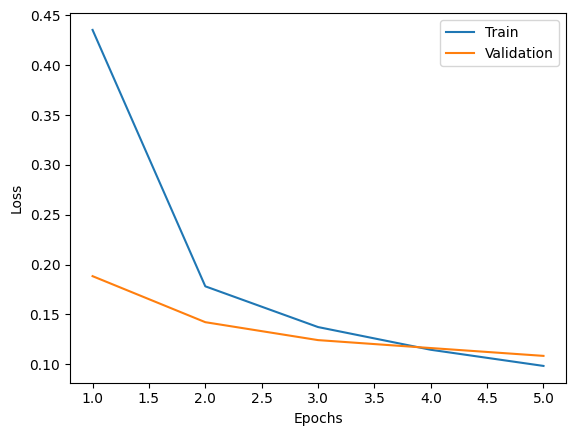

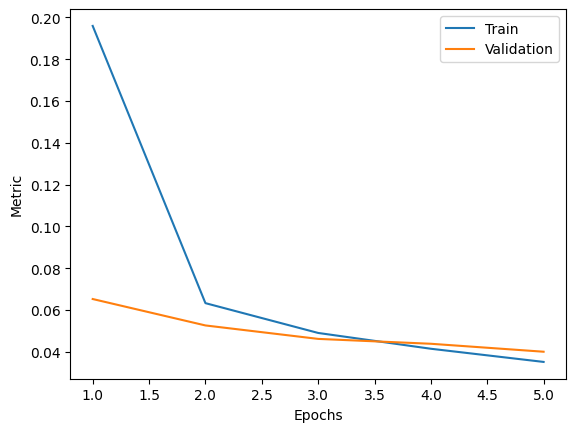

In [147]:
plot_history(train_losses, train_acc, valid_losses, valid_acc)

# **Model Checkpointing**

In [148]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'hw4_stack_exchange_model_300_embeddings'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/ColabNotebooks/NLP-HPS/Homeworks/Models/HW3_Models_Multilabel/2023-09-24_15-03-05_hw4_stack_exchange_model_300_embeddings.pt')

In [149]:
# Save the model's state dictionary to the specified file path
torch.save(model_imdb.state_dict(), path)

In [150]:
# Create an instance of the model with the same architecture
my_model = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)

<All keys matched successfully>

# **Get Accuracy, Predictions**

In [151]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    #hamming distance
    test_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            predicted = outputs>=0

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets.to(device)))

            test_hamming_distance.update(predictions,y)
    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = test_hamming_distance.compute()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy

In [152]:
# Get the prediction and accuracy
predictions_test, acc_test = get_acc_pred(test_loader, my_model, device)
predictions_train, acc_train = get_acc_pred(train_loader, my_model, device)
predictions_valid, acc_valid = get_acc_pred(valid_loader, my_model, device)

In [155]:
# Print Test Accuracy
print('Test accuracy', acc_test)
print('Train accuracy', acc_train)
print('Valid accuracy', acc_valid)

Test accuracy tensor(0.0348)
Train accuracy tensor(0.0103)
Valid accuracy tensor(0.0348)


# **Confusion Matrix for Test Data**

In [157]:
from sklearn.metrics import multilabel_confusion_matrix
# Define the human-readable class labels corresponding to the numerical class indices
classes = ['c#', 'java','php','javascript','android','jquery','c++','python','iphone','asp.net']

# Get an array containing actual labels from the testing dataset
testing_labels = np.vstack(testset.y).astype(int)
predictions = predictions_test.numpy().astype(int)

# Compute the confusion matrix between actual labels and predicted labels
cm = multilabel_confusion_matrix(testing_labels, predictions)

# Create a ConfusionMatrixDisplay object for visualization with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

<ipython-input-158-9ef7b3d0a188>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


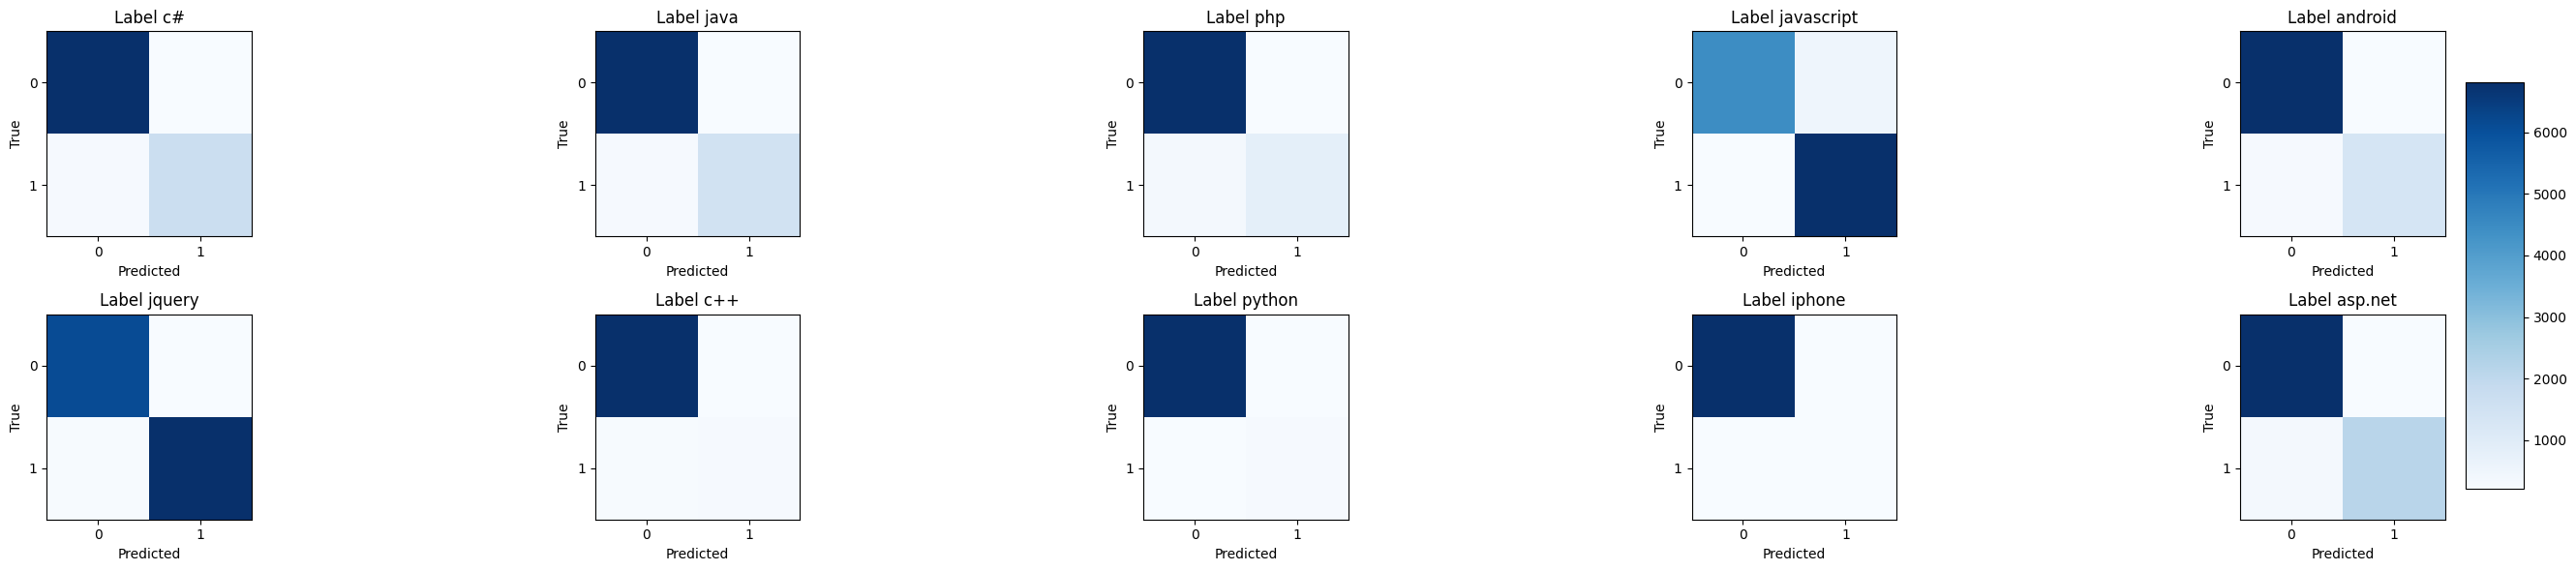

In [158]:
# Create a 2x5 grid of confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(30, 6))

for i, label_cm in enumerate(cm):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    im = ax.matshow(label_cm, cmap='Blues')
    ax.set_title(f'Label {classes[i]}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticks_position('bottom')

# Add a colorbar to the right of the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [2]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/ColabNotebooks/NLP-HPS/Homeworks/Homework-4/Pooja_Akkaladevi_HW4.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ColabNotebooks/NLP-HPS/Homeworks/Homework-4/Pooja_Akkaladevi_HW4.ipynb to pdf
[NbConvertApp] Support files will be in Pooja_Akkaladevi_HW4_files/
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW4_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW4_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW4_files
[NbConvertApp] Writing 119457 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 187261 bytes to /content/drive/MyDrive/ColabNotebooks/NLP-HPS/Homeworks/Homework-4/Pooja_Akkaladevi_HW4.pdf
